# Introduction

Drafting in Magic: The Gathering (MTG) is a complex and dynamic format that challenges players to adapt quickly, make strategic decisions, and understand the evolving meta of each new set. In this analysis, we explore the Bloomburrow (BLB) set, which was released in Arena on July 30, 2024.  We will investigate the effect of deck color choices on player win rates.

We use data from the [17Lands](17lands.com) for the premier draft format on MTG Arena, a best-of-one draft format where players draft in a pool and play until they win 7 games or lose 3.

By examining deck performance aim to uncover the key elements that contribute to success in this draft environment. Through this analysis, we provide valuable insights to help both seasoned and new drafters make more strategic decisions in the Bloomburrow draft format and beyond.

To see other analyses of MTG draft data, check out the [Draft Analysis](00-intro.ipynb) page.

In [2]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [3]:
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import to_rgba, to_hex
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import time
import polars as pl
from datetime import datetime, timedelta
from PIL import Image

In [4]:
import src.plots.annotate as anno
import src.plots.symbols as symbols

In [5]:
SET_CODE = "BLB"

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{SET_CODE}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{SET_CODE}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{SET_CODE}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{SET_CODE}_Game_PD_Cards.parquet"

In [6]:
def blend_colors(color1, color2, ratio=0.5):
    blended_rgba = tuple(
        ratio * c1 + (1 - ratio) * c2
        for c1, c2 in zip(to_rgba(color1), to_rgba(color2))
    )
    return to_hex(blended_rgba)


# https://color.adobe.com/create/image
# https://pixels.com/featured/magic-the-gathering-colors-of-mana-aurora-uyainah.html
color_palette = {
    "W": "#fffbd5",
    "U": "#aae0fa",
    "B": "#cbc2bf",
    "R": "#f9aa8f",
    "G": "#9bd3ae",
}

color_pairs = ["WU", "WB", "WR", "WG", "UR", "UG", "UB", "BG", "BR", "RG"]
for color_pair in color_pairs:
    color_palette[color_pair] = blend_colors(
        color_palette[color_pair[0]], color_palette[color_pair[1]]
    )

# Summary Data

Here we summarize key statistics from the data, reflecting the experiences of 17Lands players.

In [7]:
df_summary = pl.scan_parquet(summary_file)
df_sum = df_summary.collect().to_pandas()
print(f"Start Date: {df_sum['first_game'].dt.strftime('%Y-%m-%d').values[0]}")
print(f"Total Days: {(df_sum['last_game']-df_sum['first_game']).dt.days.values[0]}")
print(f"Total Drafts: {df_sum['n_drafts'].values[0]:,.0f}")
print(f"Total Games: {df_sum['n_games'].values[0]:,.0f}")
print(f"Win Rate: {df_sum['win_rate'].values[0]:0.1%}")
print(f"Mean Turns per Game: {df_sum['mean_turns'].values[0]:0.2f}")
print(f"Mean Games per Draft: {df_sum['n_games_per_draft'].values[0]:0.2f}")

Start Date: 2024-07-30
Total Days: 35
Total Drafts: 160,150
Total Games: 931,230
Win Rate: 54.6%
Mean Turns per Game: 8.93
Mean Games per Draft: 5.81


In [8]:
df_draft = pl.scan_parquet(draft_file)

# Color Decks

We will explore the use and importance of colors in draft decks. We will look at the frequency of color sets in decks, the win rates of color sets, and the win rates of color pairs.

## Color Frequency

We start by examining the frequency of decks drafted for each color combination in @fig-n-color-frequency. The ten two-color decks are the most common, aligning with the design intent of Bloomburrow, which focuses on ten two-color animal tribes. Although the other sets, such as [MKM](10-MKM-deck.ipynb), [OTJ](11-OTJ-deck.ipynb), and [MH3](12-MH3-deck.ipynb) also are predominately two-color, the BLB set is >90% two-color, while the others are ~70% two-color.


In [9]:
colors = (
    df_draft.group_by("main_colors")
    .agg(pl.col("n_games").count().alias("len"))
    .sort(by="len", descending=True)
    .collect()
)
colors = colors.to_pandas()
colors["Number of Main Colors"] = colors["main_colors"].str.len()
colors["pct_splash"] = colors["len"] / colors["len"].sum()
colors = colors.sort_values(["Number of Main Colors", "len"], ascending=[True, False])

colors_ct = (
    colors.groupby("Number of Main Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Main Colors"], ascending=[True])
)

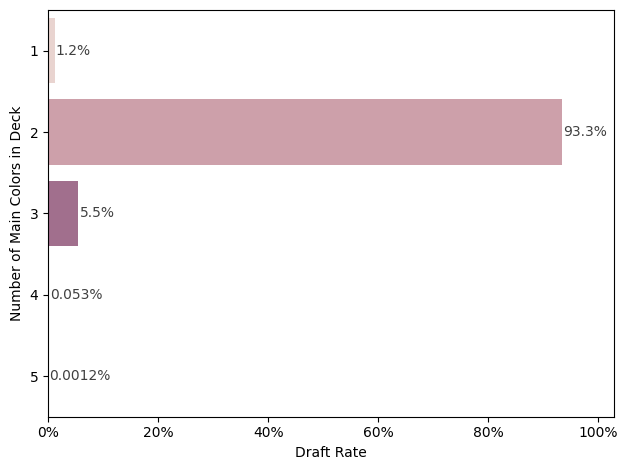

In [10]:
# | label: fig-n-color-frequency
# | fig-cap: "The rate at which the drafted deck has a given number of main colors."

sns.barplot(
    data=colors_ct,
    x="pct_splash",
    y="Number of Main Colors",
    hue="Number of Main Colors",
    orient="h",
    legend=False,
)

anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Number of Main Colors in Deck"
)

Since two-color decks are the most common, we'll focus on these pairings. In @fig-n-two-color-frequency, we see the most frequent drafted decks are Black-Green, White-Green, and Blue-GReen. On the other hand, the least drafted are Blue-Black, Blue-Red and White-Blue.


In [11]:
colors["use_rate"] = colors["len"] / colors["len"].sum()
colors = colors.sort_values("use_rate", ascending=False)

two_colors = colors[colors["main_colors"].str.len() == 2]

use_rate_mu = two_colors["use_rate"].mean()

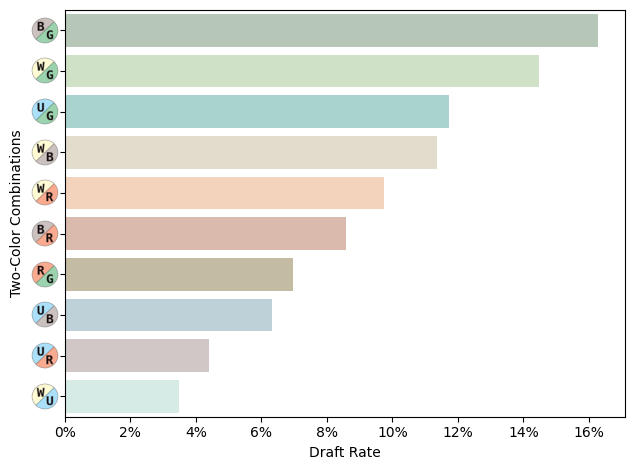

In [12]:
# | label: fig-n-two-color-frequency
# | fig-cap: "The rate at which the drafted deck is a given 2-color pair."

fig, ax = plt.subplots()
sns.barplot(
    data=two_colors,
    x="use_rate",
    y="main_colors",
    hue="main_colors",
    palette=color_palette,
    ax=ax,
)

symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Two-Color Combinations")

@fig-component-color-frequency shows the color composition of the decks. Green stands out as the most frequently drafted color, with Black and White also being popular choices. In contrast, Red and Blue are drafted far less frequently.

In [13]:
for color in ["W", "U", "B", "R", "G"]:
    colors[color] = colors["main_colors"].apply(lambda x: True if color in x else False)

dfs = []
for color in ["W", "U", "B", "R", "G"]:
    sums = colors[["len", color]].groupby(color).sum()
    use_rate = (sums.loc[True] / sums.sum()).values[0]
    dfs.append(pd.DataFrame({"color": color, "use_rate": use_rate}, index=[0]))
df = pd.concat(dfs).sort_values("use_rate", ascending=False).reset_index(drop=True)

use_rate_mu = df["use_rate"].mean()

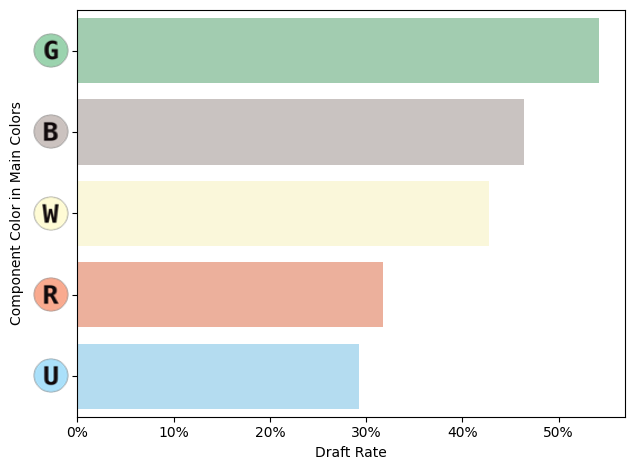

In [14]:
# | label: fig-component-color-frequency
# | fig-cap: "The rate at which the drafted deck contains a given color in the main deck colors."

fig, ax = plt.subplots()
sns.barplot(data=df, x="use_rate", y="color", hue="color", palette=color_palette, ax=ax)

symbols.add_tick_symbols(scale=0.5)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Component Color in Main Colors"
)

Next, we examine the four decks with the largest absolute changes in use between the start and end of the time period, shown in @fig-color-freq-over-time.  We see Blue-Green and White-Black increasing over time, while Red-Green and White-Red lose favor over time.


In [15]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("3d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=2))
    .collect()
    .to_pandas()
)

rank_time_sum = (
    color_time[["draft_time", "n_games"]].groupby(["draft_time"]).sum().reset_index()
)

color_time = color_time.merge(rank_time_sum, on="draft_time", suffixes=("", "_sum"))
color_time["rank_pct"] = color_time["n_games"] / color_time["n_games_sum"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]

end_mask = color_time["draft_time"] == color_time["draft_time"].max()
end_time = color_time.loc[end_mask]

start_mask = color_time["draft_time"] == color_time["draft_time"].min()
start_time = color_time.loc[start_mask]

diff_time = end_time.merge(start_time, on="main_colors", suffixes=("_end", "_start"))
diff_time["rank_diff"] = diff_time["rank_pct_start"] - diff_time["rank_pct_end"]
diff_time["abs_rank_diff"] = diff_time["rank_diff"].abs()
diff_time = diff_time.sort_values("abs_rank_diff", ascending=False)
diff_time[["abs_rank_diff", "main_colors"]]

color_decks = diff_time["main_colors"].head(4).to_list()
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

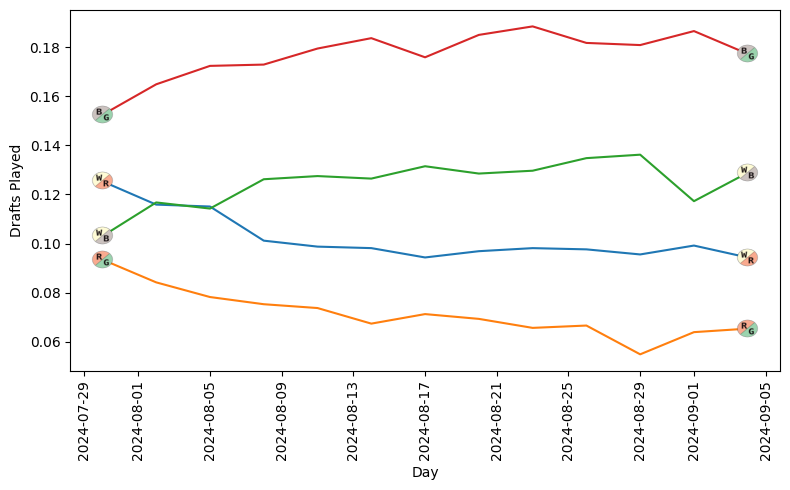

In [16]:
# | label: fig-color-freq-over-time
# | fig-cap: >
# |     Frequency of Drafted Decks by Two-Color Pair: This figure shows the rate at which
# |     different two-color pairs are drafted, highlighting trends and preferences in deck selection
# |     over time.

plt.subplots(figsize=(8, 5))
sns.lineplot(
    data=color_time,
    x="draft_time",
    y="rank_pct",
    hue="main_colors",
    hue_order=color_decks,
    legend=False,
)

symbols.add_timeseries_symbols(
    data=color_time,
    x_col="draft_time",
    y_col="rank_pct",
    label_col="main_colors",
    locs=["first", "last"],
)
anno.set_axis_labels_and_show(xlabel="Day", ylabel="Drafts Played", rot_x=True)

## Color Win Rates

In addition to analyzing the use rates of the colors, we'll also examine their win rates. First, we calculate the weighted average win rate, which is 54.60%. As highlighted in the summary section, this win rate suggests that the 17Lands player base performs better than the general draft player base.

@fig-n-color-wins presents the win rates for each color combination. While some mono-color decks have notably high win rates, their low use rates suggest that these results may be circumstantial due to small sample sizes.  OF the sets analyzed, BLB has the highest dispersion of win rates among the number of colors in the main deck.


In [58]:
mean_win_rate = df_summary.collect().to_pandas()["win_rate"].values[0]
# print(f"Average Win Percentage: {mean_win_rate:0.2%}")

In [18]:
color_wins = (
    df_draft.group_by("main_colors")
    .agg(
        pl.col("n_games").sum(),
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),
    )
    .sort(by="n_games", descending=True)
    .collect()
)
color_wins = color_wins.to_pandas()
color_wins["Number of Main Colors"] = color_wins["main_colors"].str.len()
color_wins["win_rate"] = color_wins["n_wins"] / color_wins["n_games"]
color_wins["loss_rate"] = color_wins["n_losses"] / color_wins["n_games"]
color_wins = color_wins.sort_values(
    ["Number of Main Colors", "win_rate"], ascending=[True, False]
)

color_wins_ct = (
    color_wins.groupby("Number of Main Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Main Colors"], ascending=[True])
)
color_wins_ct["win_rate"] = color_wins_ct["n_wins"] / color_wins_ct["n_games"]
color_wins_ct["loss_rate"] = color_wins_ct["n_losses"] / color_wins_ct["n_games"]

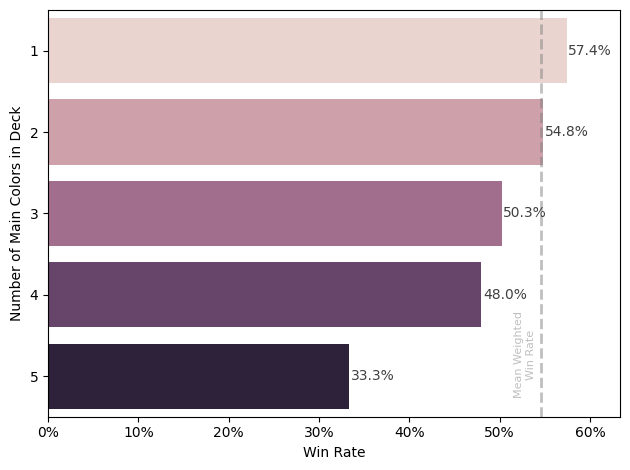

In [19]:
# | label: fig-n-color-wins
# | fig-cap: "The rate at which the drafted deck is a given 2-color pair."

sns.barplot(
    data=color_wins_ct,
    x="win_rate",
    y="Number of Main Colors",
    hue="Number of Main Colors",
    orient="h",
    legend=False,
)

anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=-0.03)
anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Number of Main Colors in Deck")

In @fig-n-two-color-wins, we focus on the 2-color decks. The Black-Red deck boasts the highest win rate, though it has a relatively low use rate. Meanwhile, the White-Red and Black-Green decks are the most popular and also maintain high win rates.


In [20]:
color_mask = color_wins["main_colors"].str.len() == 2
two_color_wins = (
    color_wins.loc[color_mask]
    .sort_values("win_rate", ascending=False)
    .reset_index(drop=True)
)

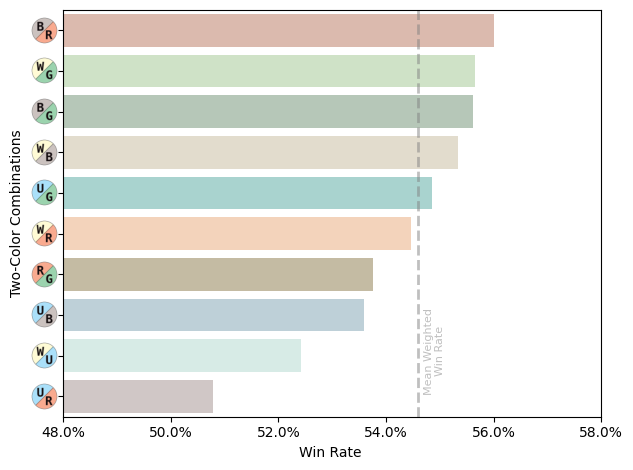

In [21]:
# | label: fig-n-two-color-wins
# | fig-cap: "The win rate for each 2-color pair."

sns.barplot(
    data=two_color_wins,
    x="win_rate",
    y="main_colors",
    hue="main_colors",
    palette=color_palette,
)
plt.gca().set(xlim=(0.48, 0.58))

anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=0.03)
symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate ", ylabel="Two-Color Combinations")

@fig-component-color-wins shows the win rates for the five primary colors, based on whether they serve as a main component in a deck. For example, the "B" results reflect the win rates for Black in decks such as WB, BG, Mono-Black, and UBR.

The decks using black perform the best, with ones using blue performing the worst. 


In [22]:
for color in ["W", "U", "B", "R", "G"]:
    color_wins[color] = color_wins["main_colors"].apply(
        lambda x: True if color in x else False
    )

dfs = []

for color in ["W", "U", "B", "R", "G"]:
    agg = color_wins.groupby(color).sum()
    agg["win_rate"] = agg["n_wins"] / agg["n_games"]
    dfs.append(
        pd.DataFrame(
            {"component_color": color, "win_rate": agg.loc[True, "win_rate"]}, index=[0]
        )
    )

df = pd.concat(dfs)
df = df.sort_values("win_rate", ascending=False).reset_index(drop=True)

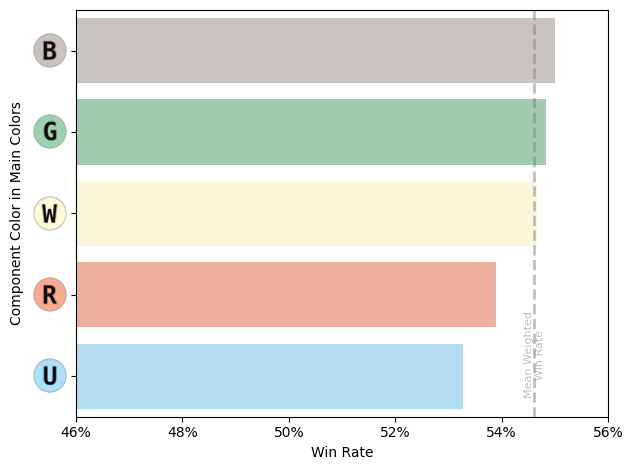

In [23]:
# | label: fig-component-color-wins
# | fig-cap: "The win rate for each given color in the main deck colors."

sns.barplot(
    data=df,
    x="win_rate",
    y="component_color",
    hue="component_color",
    palette=color_palette,
)
plt.gca().set(xlim=(0.46, 0.56))

symbols.add_tick_symbols(scale=0.5)
anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=0.0016)
anno.set_labels_to_percent(precision=1)
anno.set_axis_labels_and_show(
    xlabel="Win Rate", ylabel="Component Color in Main Colors"
)

## Win Rate over Time

It’s also insightful to observe how the win rates for two-color decks evolve over time. I selected the four decks with the largest absolute changes in win rate between the start and end of the period. In @fig-color-wins-over-time, we see that the White-Red (WR), White-Black (WB), and another White-Red (WR) deck start with high win rates but gradually decline over time. Conversely, the Blue-Red (UR) deck begins with a low win rate but shows an upward trend as time progresses.


In [24]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("7d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=5))
    .collect()
    .to_pandas()
)

color_time["win_rate"] = color_time["n_wins"] / color_time["n_games"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]

color_decks = diff_time["main_colors"].head(4).to_list()
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

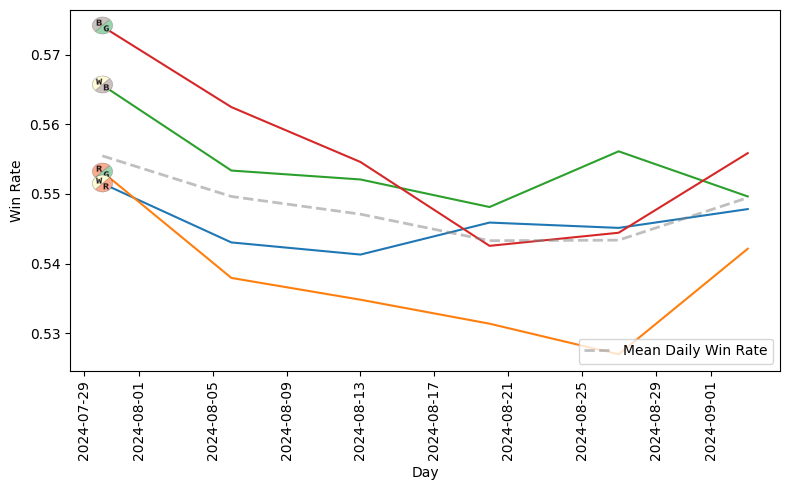

In [25]:
# | label: fig-color-wins-over-time
# | fig-cap: >
#   Win Rates of Drafted Decks by Two-Color Pair: This figure shows the win rate of
#   different two-color pairs, highlighting trends and preferences in deck performance
#   over time.

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=color_time,
    x="draft_time",
    y="win_rate",
    hue="main_colors",
    hue_order=color_decks,
    legend=False,
)

symbols.add_timeseries_symbols(
    data=color_time,
    x_col="draft_time",
    y_col="win_rate",
    label_col="main_colors",
    locs="first",
)

plt.plot(
    color_time_mean["draft_time"],
    color_time_mean["win_rate"],
    label="Mean Daily Win Rate",
    color="gray",
    linestyle="--",
    linewidth=2,
    alpha=0.5,
)

plt.legend(loc="lower right")
anno.set_axis_labels_and_show(xlabel="Day", ylabel="Win Rate", rot_x=True)

## Color Freq vs Win Rate

Next, let’s compare the use rate to the win rate to see if the player base is well-calibrated in their deck selections based on performance.

In @fig-wins-vs-freq-2color, we observe that most of the two-color decks align along a straight line, indicating a balanced relationship between use rate and win rate, with two notable outliers. The Blue-Red Otters: Non-creature Spells deck underperforms relative to its use rate, suggesting it may be over-selected. In contrast, the Black-Red Lizards: Opponents Lose Life deck is a hidden gem, boasting the highest win rates but being picked less frequently than the average two-color deck.

This under-selection of Black-Red likely stems from the general underperformance of Red, leading many drafters to avoid it unless they secure strong Black-Red cards early. On the other hand, White, Green, and Black perform well, making the BG, WG, and WB decks popular and flexible choices that players can easily pivot to during drafts.


In [26]:
paired_df = color_wins[
    ["main_colors", "win_rate", "loss_rate", "Number of Main Colors"]
]
colors["use_rate"] = colors["len"] / colors["len"].sum()
select_colors = colors[["main_colors", "use_rate"]]
paired_df = paired_df.merge(select_colors, on="main_colors")

color_mask = paired_df["Number of Main Colors"] == 2
paired_filtered_df = paired_df.loc[color_mask].reset_index(drop=True)

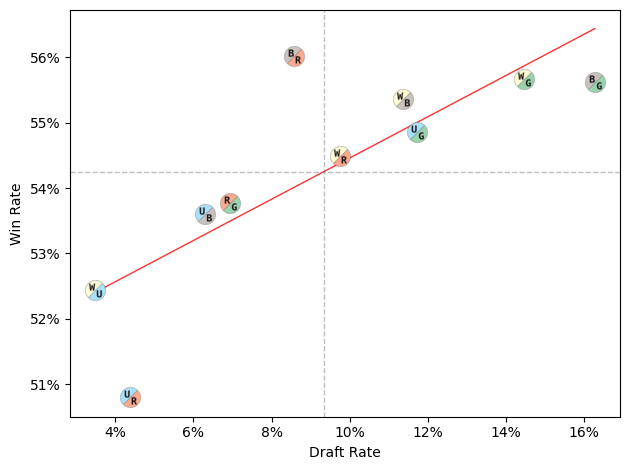

In [27]:
# | label: fig-wins-vs-freq-2color
# | fig-cap: "Win Rate vs Use Rate of 2-Color Draft Decks"

sns.regplot(
    data=paired_filtered_df,
    x="use_rate",
    y="win_rate",
    scatter=True,
    ci=None,
    line_kws={"color": "red", "linewidth": 1, "alpha": 0.8},
)

symbols.add_plot_symbols(
    data=paired_filtered_df,
    x_col="use_rate",
    y_col="win_rate",
    label_col="main_colors",
)

use_rate_mu = paired_filtered_df["use_rate"].mean()
win_rate_mu = paired_filtered_df["win_rate"].mean()
plt.axvline(use_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.axhline(win_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Win Rate")

## Wedges vs Shards

Magic: The Gathering color theory includes five wedges and five shards. Wedges are three-color decks built around a primary color and its two allies, while shards consist of a primary color and its two enemies. Conventional wisdom suggests that wedges are generally easier to draft than shards.

However, as shown in @fig-wedge-vs-shards, the shards have a slightly higher win rate and use rate compared to the wedges. This finding is somewhat unexpected but the difference is minimal.


In [28]:
wedges = ["WUG", "WUB", "WRG", "UBR", "BRG"]
shards = ["WUR", "WBG", "UBG", "URG", "WBR"]

color_wins["3_type"] = None
color_wins.loc[color_wins["main_colors"].isin(wedges), "3_type"] = "Wedge"
color_wins.loc[color_wins["main_colors"].isin(shards), "3_type"] = "Shards"
three_color_wins = color_wins.loc[color_wins["3_type"].notnull()]
three_color_wins = three_color_wins.groupby("3_type").sum()
three_color_wins["win_rate"] = three_color_wins["n_wins"] / three_color_wins["n_games"]

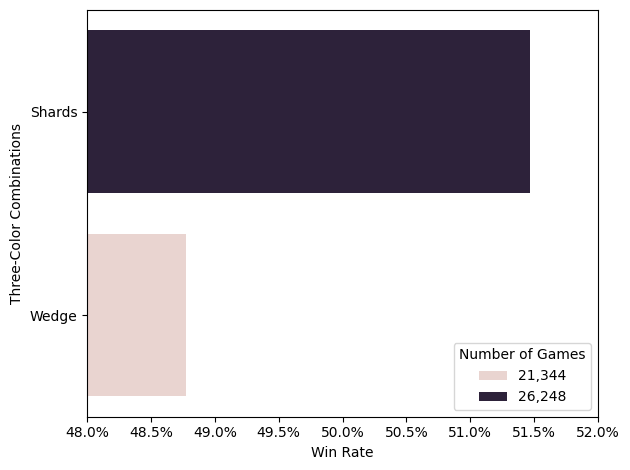

In [29]:
# | label: fig-wedge-vs-shards
# | fig-cap: "The win rate for shards versus wedges."


sns.barplot(
    data=three_color_wins,
    x="win_rate",
    y=three_color_wins.index,
    hue="n_games",
)
plt.gca().set(xlim=(0.48, 0.52))

anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Three-Color Combinations",
    legend=True,
    legend_format=",.0f",
    legend_title="Number of Games",
)

# Opposing Player Colors

We also have data on the opposing player colors, which helps us understand the draft meta. For each draft color combination, we compare the use rate of 17Lands players with that of their opponents. Each combination is color-coded to indicate whether its win rate is above or below the average win rate of the 17Lands player base. A diagonal grey line is included to show parity between the use rates of 17Lands players and the general player base.

In @fig-player-vs-opp-freq-2color, we focus on the two-color drafts. The data reveals that White-Green (WG), Black-Green (BG), and Blue-Green (UG) decks are more favored by 17Lands players and also boast higher win rates. Conversely, the Blue-Black (UB) deck is favored but has a significantly lower win rate. The other color pairs show parity between the two player bases.


In [30]:
opp_colors = (
    df_draft.group_by("opp_colors")
    .len()
    .sort(by="len", descending=True)
    .collect()
    .to_pandas()
)

opp_colors["opp_use_rate"] = opp_colors["len"] / opp_colors["len"].sum()
opp_colors = opp_colors.rename(columns=({"len": "opp_len"}))
opp_colors = opp_colors.merge(
    paired_df, left_on="opp_colors", right_on="main_colors", how="left"
)
opp_colors["Above Avg Win Rate"] = opp_colors["win_rate"] > mean_win_rate

mask = opp_colors["main_colors"].str.len() == 2
opp_colors_filtered = opp_colors.loc[mask]

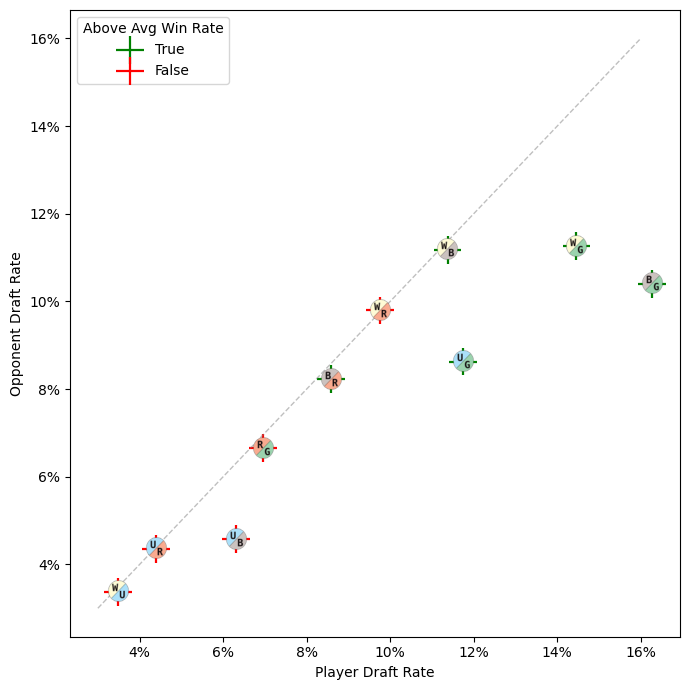

In [31]:
# | label: fig-player-vs-opp-freq-2color
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate",
    marker="+",
    hue_order=[True, False],
    palette={True: "green", False: "red"},
    s=400,
)

plt.plot(
    [0.03, 0.16], [0.03, 0.16], color="gray", linestyle="--", linewidth=1, alpha=0.5
)

symbols.add_plot_symbols(
    data=opp_colors_filtered,
    x_col="use_rate",
    y_col="opp_use_rate",
    label_col="opp_colors",
    scale=0.04,
)

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Player Draft Rate", ylabel="Opponent Draft Rate")

Looking at the non-2-color drafts in @fig-player-vs-opp-freq-non-2color, we observe that 17Lands players are far less likely to draft any color combination that isn’t a two-color deck. These non-2-color decks generally have lower win rates, with some exceptions in the mono White, Green, and Black decks.

This suggests that if a player is drafting mono White, Green, or Black, they may be better off staying mono rather than adding Blue or Red to create a two-color deck. However, since mono decks are drafted so infrequently, their strong performance might be circumstantial, depending on specific card combinations, and may not represent a consistent advantage across the entire color set.


In [32]:
mask = opp_colors["main_colors"].str.len() != 2
mask &= opp_colors["use_rate"] > 0.001
opp_colors_filtered = opp_colors.loc[mask]

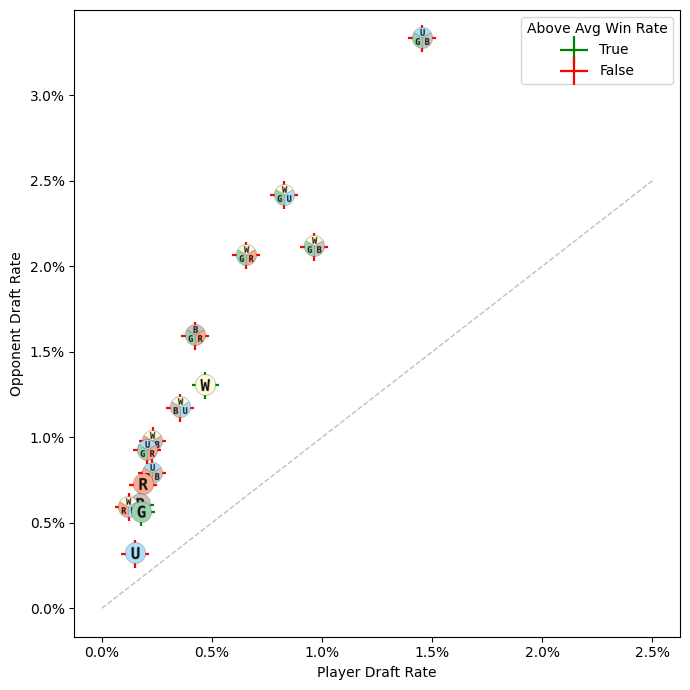

In [33]:
# | label: fig-player-vs-opp-freq-non-2color
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate",
    marker="+",
    hue_order=[True, False],
    palette={True: "green", False: "red"},
    s=400,
)

plt.plot(
    [0.0, 0.025], [0.0, 0.025], color="gray", linestyle="--", linewidth=1, alpha=0.5
)

symbols.add_plot_symbols(
    data=opp_colors_filtered,
    x_col="use_rate",
    y_col="opp_use_rate",
    label_col="opp_colors",
    scale=0.04,
)

use_rate_mu = opp_colors_filtered["use_rate"].mean()
opp_use_rate_mu = opp_colors_filtered["opp_use_rate"].mean()

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Player Draft Rate", ylabel="Opponent Draft Rate")

# Color Face-Offs (2-Color vs 2-Color)

Let’s now compare each pairing of the two-color decks in @fig-player-vs-opp-2color-freq-heat. This comparison provides insights into the strengths and weaknesses of individual decks.

We start by examining the number of games played between each pairing. The rows and columns are sorted by the maximum frequency of player deck pairings, with Black-Green (BG) vs. White-Green (WG) being the most frequent, followed by WG vs. WG matchups. The average number of games played between each pairing is 5,031.

As noted earlier, 17Lands players draft BG, WG, and Blue-Green (UG) decks more frequently than their opponents, while the other color pairs are used at near parity.


In [34]:
dual_colors = (
    df_draft.filter(
        pl.col("opp_colors").str.len_chars() == 2,
        pl.col("main_colors").str.len_chars() == 2,
        # pl.col("rank") == 'mythic',
    )
    .group_by(["opp_colors", "main_colors"])
    .agg(
        pl.col("n_games").sum(),
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),
    )
    .sort(by="n_games", descending=True)
    .collect()
)
dual_colors = dual_colors.to_pandas()
dual_colors["win_rate"] = dual_colors["n_wins"] / dual_colors["n_games"]
dual_colors["loss_rate"] = dual_colors["n_losses"] / dual_colors["n_games"]
dual_colors = dual_colors.sort_values("win_rate", ascending=False).reset_index(
    drop=True
)

dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="n_games"
)

means = dual_matrix.max(axis=1).sort_values(ascending=False)
dual_matrix = dual_matrix.loc[means.index, means.index]
pair_mean = dual_matrix.mean().mean()

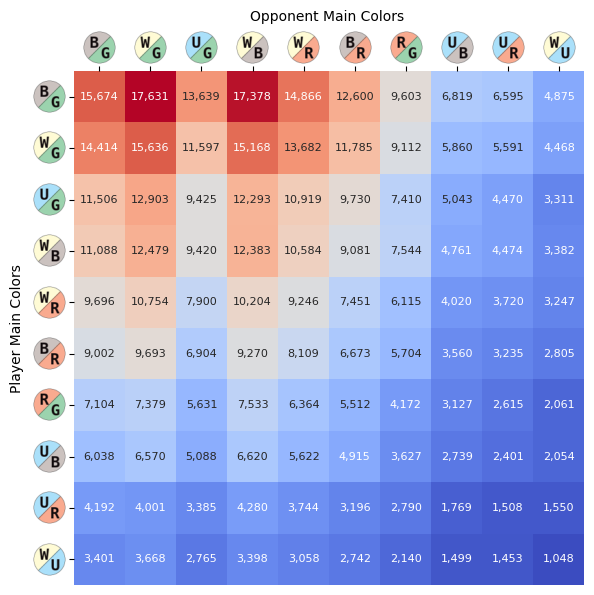

In [35]:
# | label: fig-player-vs-opp-2color-freq-heat
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=",.0f",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)

symbols.add_heatmap_symbols()
anno.set_axis_labels_and_show(
    xlabel="Opponent Main Colors ", ylabel="Player Main Colors"
)

Next, we examine the pair-wise win rates for players in @fig-player-vs-opp-2color-wins-heat.

The most notable observation is that the 17Lands player base performs well in most matchups, with a significant exception for the Blue-Red (UR) deck. On average, UR matchups underperform by about 4 percentage points compared to similar matchups. Notably, the UR vs. UR matchup is exceptionally low and is the only like-paired matchup with win rates below 50%, indicating less than even odds of winning.


In [36]:
dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="win_rate"
)

dual_matrix = dual_matrix.loc[means.index, means.index]

pair_mean = dual_matrix.mean().mean()

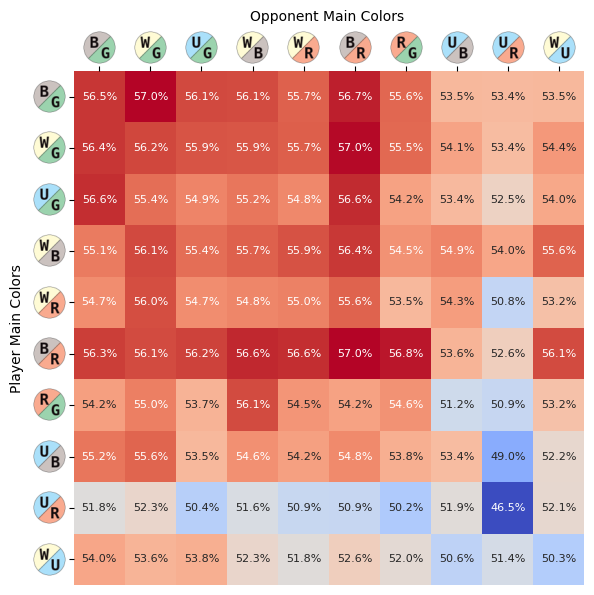

In [37]:
# | label: fig-player-vs-opp-2color-wins-heat
# | fig-cap: "Win Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=".1%",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)

symbols.add_heatmap_symbols()
anno.set_axis_labels_and_show(
    xlabel="Opponent Main Colors ", ylabel="Player Main Colors"
)

# Color Splash

Splash colors are 1-3 non-land spell cards of a given color that enhance a deck without significantly diluting its main colors. These splash cards are often very powerful and can provide strategic advantages.

In @fig-n-color-splash-freq, we can see how frequently splashing occurs across different decks.


In [38]:
splash = (
    df_draft.group_by("splash_colors")
    .agg(
        pl.col("n_games").count().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="len", descending=True)
    .collect()
    .to_pandas()
)

splash["splash_colors"] = splash["splash_colors"].fillna("")
splash["Number of Splash Colors"] = splash["splash_colors"].str.len()
splash["splash_colors"] = splash["splash_colors"].replace({"": "None"})
splash["pct_splash"] = splash["len"] / splash["len"].sum()
splash = splash.sort_values(["Number of Splash Colors", "len"], ascending=[True, False])

splash_ct = (
    splash.groupby("Number of Splash Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Splash Colors"], ascending=[True])
)

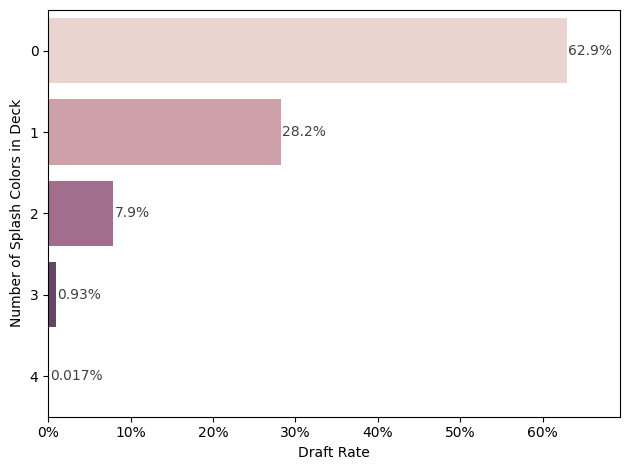

In [39]:
# | label: fig-n-color-splash-freq
# | fig-cap: "The frequency of splash colors."

sns.barplot(
    data=splash_ct,
    x="pct_splash",
    y="Number of Splash Colors",
    hue="Number of Splash Colors",
    orient="h",
    legend=False,
)

anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Number of Splash Colors in Deck"
)

In @fig-component-splash-freq, we observe the frequency of splashing for each color. Blue is the most commonly splashed color, while Green is the least common.


In [40]:
splash_1 = splash.loc[splash["Number of Splash Colors"] == 1]

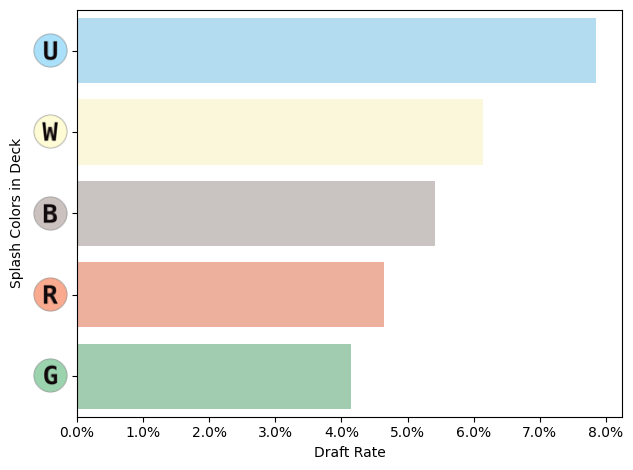

In [41]:
# | label: fig-component-splash-freq
# | fig-cap: "The rate at which the drafted deck contains a given splash color."

sns.barplot(
    data=splash_1,
    x="pct_splash",
    y="splash_colors",
    hue="splash_colors",
    palette=color_palette,
)

symbols.add_tick_symbols(scale=0.5)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Splash Colors in Deck")

In [42]:
draft_rank = (
    df_draft.group_by("rank")
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)

ordered_ranks = {
    0: "bronze",
    1: "silver",
    2: "gold",
    3: "platinum",
    4: "diamond",
    5: "mythic",
}

ordered_ranks_df = pl.LazyFrame(
    {"rank_value": list(ordered_ranks.keys()), "rank": list(ordered_ranks.values())}
).with_columns(
    # Create the rank_name column
    (pl.col("rank_value").cast(str) + " " + pl.col("rank").str.to_uppercase()).alias(
        "rank_name"
    )
)

ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

ranks["win_rate"] = ranks["n_wins"] / ranks["n_games"]

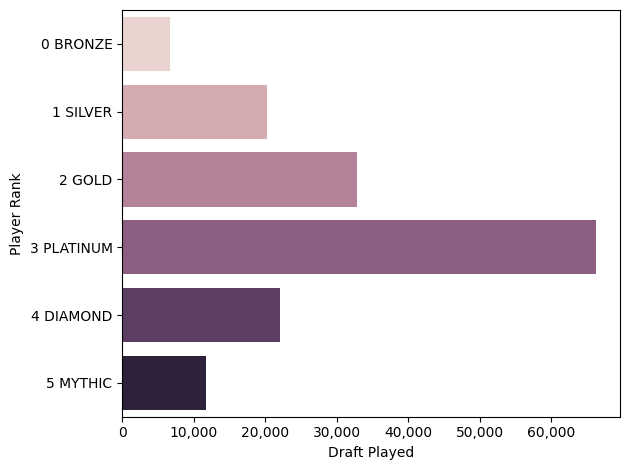

In [43]:
# | label: fig-rank-games
# | fig-cap: "Drafts Played by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="len", hue="rank_value", legend=False)
anno.set_labels_to_commas()
anno.set_axis_labels_and_show(xlabel="Draft Played", ylabel="Player Rank")

In @fig-ranks-win-rate, we observe that win rates vary by rank, with higher ranks generally achieving higher win rates. The Bronze rank has by far the lowest win rate, reflecting new or less skilled players. Interestingly, the Silver rank shows the highest win rate, likely due to the influx of Gold and Platinum players who reset to Silver at the start of the season and quickly climb back up the ranks.


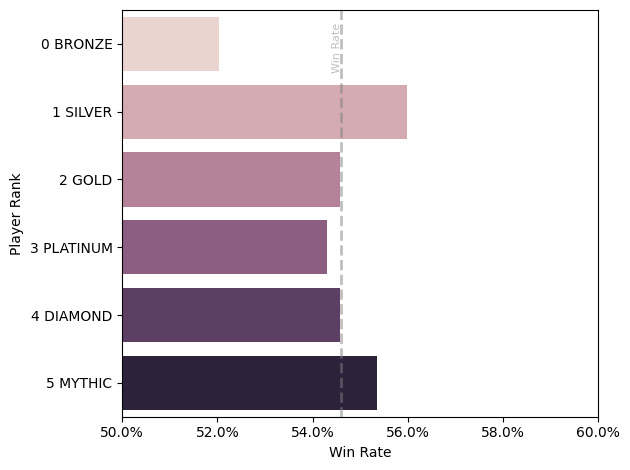

In [44]:
# | label: fig-ranks-win-rate
# | fig-cap: "Win Rate by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="win_rate", hue="rank_value", legend=False)
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=-0.01)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Player Rank")

For each rank, I plotted the win rate for the last week of play compared to the earlier timeframe. In @fig-ranked-win-rate-over-time, we see a decline in win rates for higher ranks but an increase in win rates for lower ranks. This pattern suggests that higher ranks may become more competitive as the season progresses, while lower ranks tend to become more casual.


In [45]:
max_date = df_draft.select(pl.col("draft_time").max()).collect().to_series()[0]

draft_rank = (
    df_draft.with_columns(
        (pl.col("draft_time") >= (max_date - pl.duration(days=6))).alias("last_week")
    )
    .group_by(["rank", "last_week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)


week_ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

week_ranks["win_rate"] = week_ranks["n_wins"] / week_ranks["n_games"]

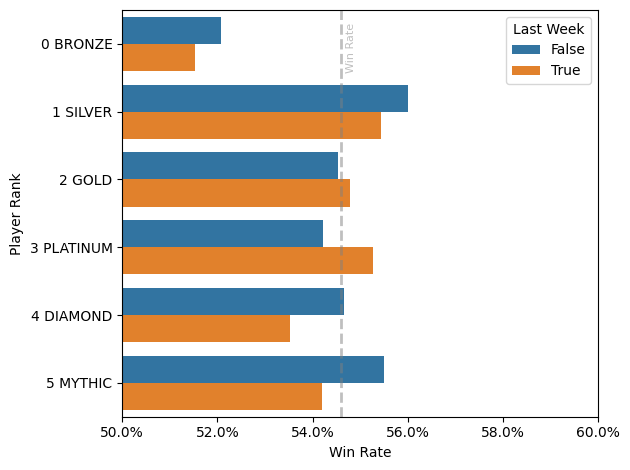

In [46]:
# | label: fig-ranked-win-rate-over-time
# | fig-cap: "Win Rate by Players of Different Ranks by Timeframe."

sns.barplot(data=week_ranks, y="rank_name", x="win_rate", hue="last_week")
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=0.02)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Player Rank",
    legend=True,
    legend_title="Last Week",
)

@fig-ranked-n-games shows the number of games played per draft for each rank. While not identical, the pattern closely mirrors the previous chart of win rates.


In [47]:
ranks["games_per_draft"] = ranks["n_games"] / ranks["len"]
mean_games_played = df_draft.select(pl.col("n_games").mean()).collect().to_numpy()[0][0]

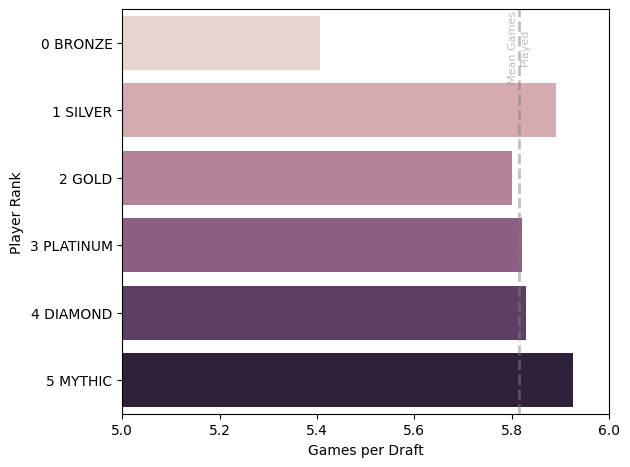

In [48]:
# | label: fig-ranked-n-games
# | fig-cap: "Games Played per Draft by Players of Different Ranks."

sns.barplot(
    data=ranks, y="rank_name", x="games_per_draft", hue="rank_value", legend=False
)
plt.gca().set(xlim=(5, 6))

anno.plot_vert_line(
    x=mean_games_played, label="Mean Games\nPlayed", y_pos=0.01, offset=0.0
)
anno.set_axis_labels_and_show(xlabel="Games per Draft", ylabel="Player Rank")

## Ranks over Time


We then examine the number of drafts played at each rank over time in @fig-ranked-drafts-over-time. Since the BLB set was released two days before the season start, I truncated the data at 08-01 to avoid the effects of rank decay.

The initial days are chaotic, with the BLB set launching on 07-30, and 07-31 being the first full day of recorded games. On 08-01, the new ranked season began, causing rank decay, which is especially noticeable in Mythic and Diamond gameplay.

Starting on 08-01, we observe distinct patterns: Gold rapidly declines after an initial peak of 3,800 drafts per day. Platinum peaks during days 4-6 before dropping. Diamond shows a slower climb with a plateau between days 8-13, followed by a gradual decline. Mythic starts at zero and slowly climbs, reaching a peak of 500 drafts per day around days 13-16.

From this chart, it's unclear how much of the decline at each rank is due to player advancement versus a loss of interest after the initial excitement of a new season. In the following charts, I will normalize the data to the total drafts played to better account for the overall decrease in gameplay.


In [49]:
rank_time_df = (
    df_draft.group_by(
        pl.col("draft_time").dt.truncate("1d")  # Truncate datetime to day
    )
    .agg(
        [
            pl.col("rank")
            .value_counts()
            .alias("rank_counts")  # Count occurrences of each rank
        ]
    )
    .explode("rank_counts")
    .with_columns(
        # Extract rank and count from the exploded struct
        pl.col("rank_counts").struct.field("rank").alias("rank"),
        pl.col("rank_counts").struct.field("count").alias("count"),
    )
    .drop("rank_counts")
    .join(ordered_ranks_df, on="rank", how="left")
    .sort(by=["draft_time", "rank_name"], descending=False)
    .collect()
    .to_pandas()
)

# trim partial first day
rank_time_df = rank_time_df.loc[
    rank_time_df["draft_time"] > rank_time_df["draft_time"].min()
]

first_days = rank_time_df["draft_time"][
    rank_time_df["draft_time"].dt.is_month_start
].drop_duplicates()

In [50]:
print(
    f"Total Time Interval: {(rank_time_df['draft_time'].max() - rank_time_df['draft_time'].min()).days} days"
)

Total Time Interval: 34 days


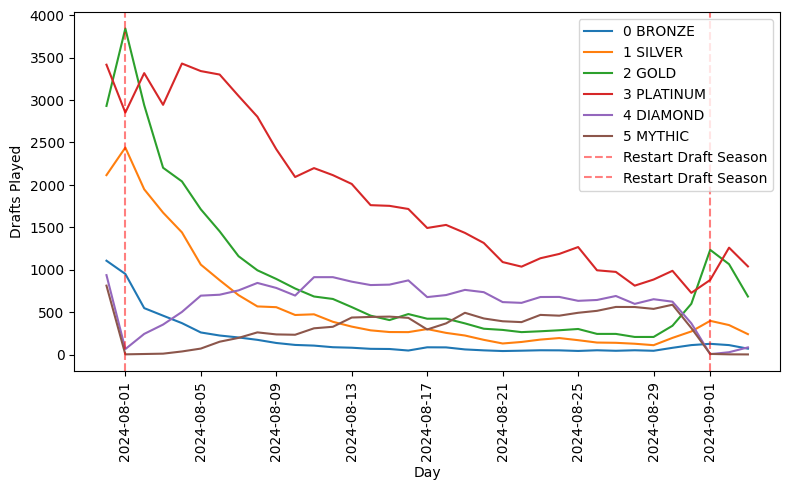

In [51]:
# | label: fig-ranked-drafts-over-time
# | fig-cap: "Drafts Played by Players Over Time, by Player rank."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df, x="draft_time", y="count", hue="rank_name")

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

In @fig-ranked-total-drafts-over-time, we see the number of drafts played over time. It's notable that the release of BLB and the start of the new season coincided, driving high player interest, with a peak of 11,300 drafts on 07-31. The rate of play decayed over the weeks, reaching a low of 3,100 on 08-17.

The decline is nearly monotonic, with slight increases on the Saturdays of 08-04 and 08-11, indicating that weekly seasonality has only a minor impact.

Releasing new sets clearly boosts player engagement. However, the introduction of the new season on 08-01 does not appear to have significantly increased play, though this observation is tentative. This data highlights the economic motivation for releasing new sets to drive digital engagement on Arena, and it’s likely that paper play would follow a similar trend, with increased draft activity consuming more booster packs in the weeks following a new set’s launch.

It would be valuable to compare this pattern across different set releases to better understand the player base’s set-by-set preferences.


In [52]:
rank_time_sum = (
    rank_time_df[["draft_time", "count"]].groupby(["draft_time"]).sum().reset_index()
)

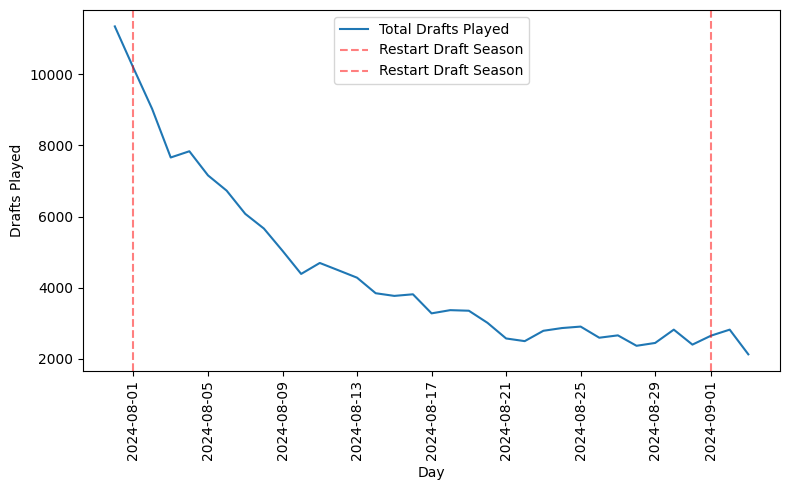

In [53]:
# | label: fig-ranked-total-drafts-over-time
# | fig-cap: "Total Drafts Played by Players Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_sum, x="draft_time", y="count", label="Total Drafts Played")

plt.xlim = (pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.ylim = (0, 12000)

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )


anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

Next, we normalize for the total games played to observe the relative ranked play across the player base, as shown in @fig-normalized-ranked-drafts-over-time.

This normalization highlights the relative activity at each rank more clearly. After the season starts, Gold exhibits a linear decay as players progress to Platinum. Platinum maintains a prolonged plateau, indicating a balance between new players entering the rank and existing players advancing.

Diamond and Mythic both start with minimal participation but gradually increase in play almost monotonically, albeit at different rates.


In [54]:
rank_time_df2 = rank_time_df.merge(
    rank_time_sum, on="draft_time", suffixes=("", "_sum")
)
rank_time_df2["rank_pct"] = rank_time_df2["count"] / rank_time_df2["count_sum"]

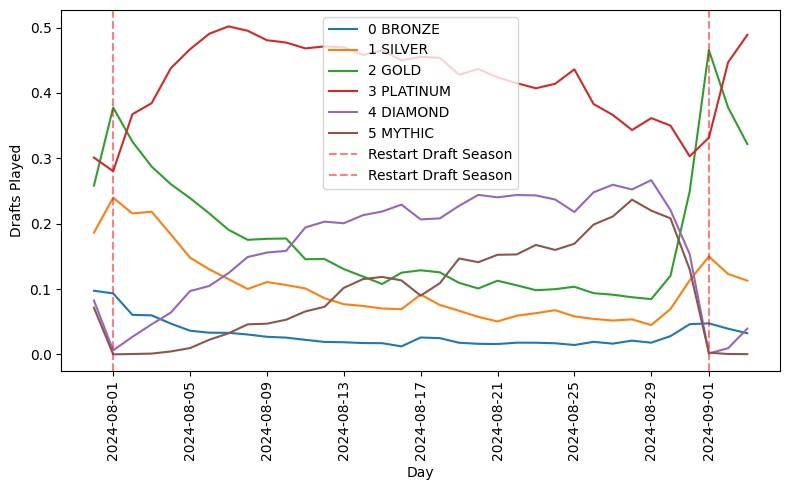

In [55]:
# | label: fig-normalized-ranked-drafts-over-time
# | fig-cap: "Normalized Drafts Played by Players of Different Ranks Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="rank_pct", hue="rank_name")

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

## Low vs High Rank Players

Now, let's compare player rank performance against success by focusing on the three two-color decks that were outliers in the previous use-rate versus win-rate chart.

| Deck | Use Rate | Win Rate      |
| ---- | -------- | ------------- |
| BG   | High     | High          |
| BR   | Low      | High          |
| UR   | Very Low | Extremely Low |

In @fig-top-decks-by-rank, we analyze the overall performance of players using these decks, categorized by the week of play and whether the player is in the elite ranks of Diamond or Mythic.

For BG, the most played deck, performance across weeks and ranks shows no clear trend. However, for the BR and UR decks, which are less frequently played, players in both elite ranks demonstrated noticeable improvements in win rates from week one to week two. This suggests that the 17Lands player base adapted and learned to optimize these less favorable decks, regardless of their rank.

It's important to note that during the first week of play, the Mythic and Diamond player base is relatively small.


In [56]:
draft_rank_deck = (
    df_draft.with_columns(
        (
            (
                (pl.col("draft_time") - pd.to_datetime("2024-07-30"))
                / pd.Timedelta(days=7)
            ).cast(pl.Int64)
        ).alias("week"),
        (pl.col("rank").is_in(["mythic", "diamond"])).alias("elite_ranks"),
    )
    .filter(
        pl.col("main_colors").is_in(["BG", "BR", "UR"]),
    )
    .group_by(["rank", "main_colors", "week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
        pl.col("elite_ranks").first(),
    )
    .sort(by="n_wins", descending=True)
)

ranks_deck = (
    ordered_ranks_df.join(draft_rank_deck, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()
ranks_deck["win_rate"] = ranks_deck["n_wins"] / ranks_deck["n_games"]

ranks_deck = ranks_deck.rename(
    columns={
        "elite_ranks": "Rank of Mythic or Diamond",
        "week": "Week of Play",
        "main_colors": "Player Deck Colors",
        "win_rate": "Player Win Rate",
    }
)

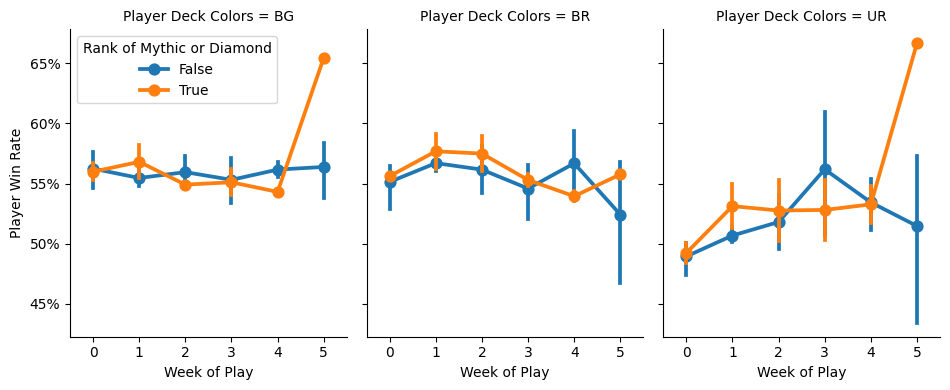

In [57]:
# | label: fig-top-decks-by-rank
# | fig-cap: "Win Rate for given color decks for top-ranked players vs others."

sns.catplot(
    data=ranks_deck,
    x="Week of Play",
    y="Player Win Rate",
    hue="Rank of Mythic or Diamond",
    kind="point",
    col="Player Deck Colors",
    height=4,
    aspect=0.8,
    legend_out=False,
)

anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show()

# Conclusion

This analysis of the Bloomburrow draft data provides valuable insights into the dynamics of deck performance, player strategies, and overall gameplay within the set. Key findings include the strong influence of deck choice and mulligan decisions on win rates, the advantages of starting first, and the nuanced impact of rebuilding decks during draft sessions. We observed that players often align closely with expected use rates and win rates, but there are clear areas where player behavior diverges, such as the under-selection of high-performing but less popular decks like Black-Red.

The data suggests that set release timing, player rank progression, and strategic decisions such as mulligan frequency and rebuilding all play significant roles in shaping the draft meta. While certain trends, such as the consistent advantage of starting first, are clear, other factors like the impact of sideboarding and deck rebuilding require further exploration, particularly through a deeper analysis of card-level data.

Ultimately, understanding these patterns can help players refine their drafting and gameplay strategies, making more informed decisions to enhance their success in both digital and paper formats. Future work could focus on comparing these trends across different set releases to identify broader shifts in player behavior and preferences.
